# Data Loader

In [1]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re

In [2]:
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report

In [5]:
training_file = path.join('semeval2016-task6-trainingdata.txt')
training_data = pd.read_csv(training_file, header=0, delimiter='\t')

In [6]:
training_data

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST
...,...,...,...,...
2809,2910,Legalization of Abortion,"There's a law protecting unborn eagles, but no...",AGAINST
2810,2911,Legalization of Abortion,I am 1 in 3... I have had an abortion #Abortio...,AGAINST
2811,2912,Legalization of Abortion,How dare you say my sexual preference is a cho...,AGAINST
2812,2913,Legalization of Abortion,"Equal rights for those 'born that way', no rig...",AGAINST


# Preprocessing

In [7]:
def preprocess(text):
    #convert text to lower case
    text = text.lower()
   
    #removing whitespace
    text.strip()
   
    #removing digits
    text = gensim.parsing.preprocessing.strip_numeric(text)
    #text = ' '.join(s for s in text.split() if not any(c.isdigit() for c in s))
    
    #remove stopwords
    text = gensim.parsing.preprocessing.remove_stopwords(text)
    
    #strip punctutation
    text = gensim.parsing.preprocessing.strip_punctuation(text)
    
    #strip multiple whitepsace that might occur after we remove stopwords
    text = gensim.parsing.preprocessing.strip_multiple_whitespaces(text)

    p = PorterStemmer()
    
    text = ' '.join(p.stem(word) for word in text.split())    

    #print(text)
    
    return text

In [8]:
training_data['Tweet'] = training_data['Tweet'].map(preprocess)

In [9]:
training_data

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u ur bless forgiv sin lord str...,AGAINST
1,102,Atheism,bless peacemak shall call children god matthew...,AGAINST
2,103,Atheism,conform world transform renew mind ispeaklif g...,AGAINST
3,104,Atheism,salah prai focu understand allah warn lazi pra...,AGAINST
4,105,Atheism,stai hous displai like time ignor quran islam ...,AGAINST
...,...,...,...,...
2809,2910,Legalization of Abortion,there s law protect unborn eagl human uh idk y...,AGAINST
2810,2911,Legalization of Abortion,abort abortionondemand menstruationmatt semst,AGAINST
2811,2912,Legalization of Abortion,dare sexual prefer choic dare dismemb preborn ...,AGAINST
2812,2913,Legalization of Abortion,equal right born wai right born liberallog lib...,AGAINST


# Train and Test by SVM

In [10]:
train, test = train_test_split(training_data, test_size=0.3)

In [48]:
train0, val = train_test_split(train, test_size=0.3)

In [60]:
train_d = [tweet for tweet in train['Tweet'] + ' ' + train['Target']]
test_d = [tweet for tweet in test['Tweet'] + ' ' + test['Target']]
val_d = [tweet for tweet in val['Tweet'] + ' ' + val['Target']]
# train_d = [tweet for tweet in train['Tweet']]
# test_d = [tweet for tweet in test['Tweet']]
# val_d = [tweet for tweet in val['Tweet']]

In [41]:
type(test_d)

list

In [66]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, 
                              binary=True, norm='l2', use_idf=True, 
                              smooth_idf=False, sublinear_tf=True, encoding='latin1')

In [61]:
X_train = vectorizer.fit_transform(train_d)
X_test = vectorizer.transform(test_d)
X_val = vectorizer.fit_transform(val_d)
Y_train = np.asarray([stance for stance in train['Stance']])
Y_test = np.asarray([stance for stance in test['Stance']])
Y_val = np.asarray([stance for stance in val['Stance']])

0.5360946745562131 0.7543120063354607


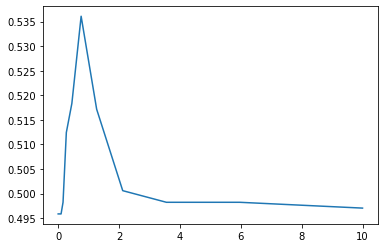

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

score = []
gamma_range = np.logspace(-10, 1, 50)  
for i in gamma_range:
    clf = SVC(kernel="rbf", gamma=i, cache_size=5000).fit(X_train, Y_train)
    score.append(clf.score(X_test, Y_test))
print(max(score), gamma_range[score.index(max(score))])
plt.plot(gamma_range, score)
plt.show()

In [62]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [63]:

gamma_range = np.logspace(-10, 1, 20)
coef0_range = np.linspace(0, 5, 10)
param_grid = dict(gamma=gamma_range,
                  coef0=coef0_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=420)
grid = GridSearchCV(SVC(kernel="poly", degree=1, cache_size=5000),
                    param_grid=param_grid, cv=cv)
grid.fit(X_train, Y_train)
print("The best parameters are %s with a score of %0.5f" % (grid.best_params_,
                                                            grid.best_score_))

The best parameters are {'coef0': 0.0, 'gamma': 2.636650898730366} with a score of 0.59628


In [64]:
print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = Y_test, grid.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:

{'coef0': 0.0, 'gamma': 2.636650898730366}

Grid scores on development set:

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

     AGAINST       0.68      0.76      0.72       419
       FAVOR       0.51      0.51      0.51       211
        NONE       0.57      0.44      0.50       215

    accuracy                           0.62       845
   macro avg       0.59      0.57      0.58       845
weighted avg       0.61      0.62      0.61       845

